In [1]:
import pandas as pd
import re
import numpy as np
import fsspec
import os
import rasterio as rio
import matplotlib.pyplot as plt
import boto3

In [2]:
def rastermath(ensemble_list, iteration):
    
    # Purpose: To calculate the mean across X ensembles for each ith pixel
    
    # Returns a tuple with the first element the array, and the second the metadata of the the geoTiff file
    
    array_list=[]

    for j in range(0, len(ensemble_list)):
        dataset = ensemble_list[j]
        
        raster_array_read = dataset.read(iteration+1, masked=False) # fixed from masked=False to masked=True on 8/17/2020 - this applied to the gridMET data
        raster_meta = dataset.profile

        array_list.append(raster_array_read)
        
        array_mean = array_list[0]
        
    return array_mean, raster_meta

In [3]:
def grepfxn(pattern,files):
    # Purpose: this function 
    precip_asc_df2=pd.DataFrame(files)
    idx_asc_in2 = []
    for i, precipfile in precip_asc_df2.iterrows():
        val = re.findall(pattern, precipfile.iloc[0])
        if len(val) > 0:
            idx_asc_in2.append(i)
            
    ascfileround2 = [files[i] for i in idx_asc_in2]
    return ascfileround2

In [4]:
def write_geotiff(data,meta,var_name,startyear,endyear,folder):
    
    # Now we need to convert all of these arrays back to rasterio geoTIFFs
    
    os.chdir(folder+'/'+var_name)
    
    filename = var_name +'_' + str(startyear) + '_' +str(endyear) +'.tif'
    with rio.open(filename, 'w', **meta) as dst:
        dst.write(data, 1)
        
    return filename

In [5]:
def s3_push_delete_local(local_file, bucket, bucket_filepath):
        """
        This function will move the model outputs from a local folder to a cloud bucket.
        :param local_file: path the the local geo file
        :param outpath: path of a directory to be created in the cloud bucket
        :param bucket: name of the cloud bucket = 'dev-et-data'
        :param bucket_folder: "folder" in cloud bucket  = 'v1DRB_outputs'
        :return:
        """

        s3 = boto3.client('s3')
        with open(local_file, "rb") as f:
            print(bucket, bucket_filepath)
            s3.upload_fileobj(f, bucket, bucket_filepath)
        os.remove(local_file)

In [6]:
averaging_years = np.arange(1950, 2110, 10).tolist();print(averaging_years)

# num_years = 10

# print(np.arange(1950, 1960, 1))
# averaging_years[0]
# averaging_years[1]

[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]


In [8]:
fs = fsspec.filesystem('s3', anon=False, requester_pays=True)
all_files = fs.find('dev-et-data/in/DelawareRiverBasin/ETo/')

In [10]:
year_block_annual

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [9]:
# averaging_years2 = averaging_years[0:2]

block_averaged_list = []
for i in range(0,len(averaging_years)-1): # loop by the defined averaging block e.g. 1950, 1960, 1970 etc. for 10 years
    year_block_annual = np.arange(averaging_years[i], averaging_years[i+1], 1) # create list of annual to loop by next
#     print(year_block_annual)
    block_daily_annual_list = []        
        
    for year_annual_loop in range(0, len(year_block_annual)): # loop by each year in the defined blocking period

        # get only the matching filenames for that year
        year_annual_loop_geotiff = grepfxn(str(year_block_annual[year_annual_loop]),all_files)
            
        for year_daily_loop in range(0, len(year_annual_loop_geotiff)): # loop by all days within the given year

            year_daily_loop_geotiff = year_annual_loop_geotiff[year_daily_loop]

            daily_constructed_filename = "s3://" + year_daily_loop_geotiff 

            open_daily_geotiff = rio.open(daily_constructed_filename)

            block_daily_annual_list.append(open_daily_geotiff)
            
    averaged_array = rastermath(block_daily_annual_list,0)
        
#     block_averaged_list.append(averaged_array)
        
    averaged_array[1]['count']=1
    
    # Much like for the original reference evapotranspiration images, write the geotiffs to the local mini-pangeo
    # and then push that to the cloud (while deleting the copy in mini-pangeo)
    
    os.chdir('/home/jupyter-rouze')
    gTIFF_filename = write_geotiff(data=averaged_array[0],meta=averaged_array[1],var_name='reference_evapotranspiration',
                                   startyear=averaging_years[i],endyear=averaging_years[i+1],folder='in')

    local_file = 'in' +'/' + 'reference_evapotranspiration' + '/' + gTIFF_filename 
    bucket = 'dev-et-data'

    bucket_filepath = 'in/DelawareRiverBasin/ETo_Moving_Average/' + gTIFF_filename 

    os.chdir('/home/jupyter-rouze')
    s3_push_delete_local(local_file, bucket, bucket_filepath)
    
    block_daily_annual_list = []     

dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_1950_1960.tif
dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_1960_1970.tif
dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_1970_1980.tif
dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_1980_1990.tif
dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_1990_2000.tif
dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_2000_2010.tif
dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_2010_2020.tif
dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_2020_2030.tif
dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_2030_2040.tif
dev-et-data in/DelawareRiverBasin/ETo_Moving_Average/reference_evapotranspiration_2040_2050.tif
dev-et-data in/DelawareRiverBasin/ETo_Mo

In [135]:
averaging_years

[1950,
 1960,
 1970,
 1980,
 1990,
 2000,
 2010,
 2020,
 2030,
 2040,
 2050,
 2060,
 2070,
 2080,
 2090,
 2100]

In [ ]:
os.chdir('/home/jupyter-rouze')
gTIFF_filename = write_geotiff(data=averaged_array[0],meta=averaged_array[1],var_name='reference_evapotranspiration',
                               startyear=averaging_years[i],endyear=averaging_years[i+1],folder='in')

In [131]:
print(averaged_array)
print(year_block_annual)
print(averaged_array[0])
averaged_array[1]['count']=1

# Much like for the original reference evapotranspiration images, write the geotiffs to the local mini-pangeo
# and then push that to the cloud (while deleting the copy in mini-pangeo)

(array([[1.24, 1.29, 1.32, ...,  nan,  nan,  nan],
       [1.21, 1.27, 1.29, ...,  nan,  nan,  nan],
       [1.18, 1.25, 1.27, ...,  nan,  nan,  nan],
       ...,
       [0.6 , 0.6 , 0.6 , ..., 0.91, 0.92, 0.92],
       [0.57, 0.57, 0.58, ..., 0.92, 0.94, 0.93],
       [0.55, 0.54, 0.54, ..., 0.93, 0.95, 0.95]], dtype=float32), {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 74, 'height': 119, 'count': 1, 'crs': None, 'transform': Affine(0.04166610926797945, 0.0, -76.793782273384,
       0.0, 0.041665998555846136, 38.083704964589266), 'tiled': False, 'interleave': 'band'})
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979]
[[1.24 1.29 1.32 ...  nan  nan  nan]
 [1.21 1.27 1.29 ...  nan  nan  nan]
 [1.18 1.25 1.27 ...  nan  nan  nan]
 ...
 [0.6  0.6  0.6  ... 0.91 0.92 0.92]
 [0.57 0.57 0.58 ... 0.92 0.94 0.93]
 [0.55 0.54 0.54 ... 0.93 0.95 0.95]]


In [127]:
os.chdir('/home/jupyter-rouze')
gTIFF_filename = write_geotiff(data=averaged_array,meta=averaged_array[1],var_name='reference_evapotranspiration',
                               doy=doy_loop,year=year_loop,folder=output_folder)

local_file = output_folder+'/' + 'reference_evapotranspiration' + '/' + gTIFF_filename 
bucket = 'dev-et-data'

bucket_filepath = 'in/DelawareRiverBasin/ETo_Moving_Average/'+ str(year_loop)  + '/' + gTIFF_filename 

os.chdir('/home/jupyter-rouze')
s3_push_delete_local(local_file, bucket, bucket_filepath)

block_daily_annual_list = []
        

(array([[1.24, 1.29, 1.32, ...,  nan,  nan,  nan],
        [1.21, 1.27, 1.29, ...,  nan,  nan,  nan],
        [1.18, 1.25, 1.27, ...,  nan,  nan,  nan],
        ...,
        [0.6 , 0.6 , 0.6 , ..., 0.91, 0.92, 0.92],
        [0.57, 0.57, 0.58, ..., 0.92, 0.94, 0.93],
        [0.55, 0.54, 0.54, ..., 0.93, 0.95, 0.95]], dtype=float32),
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 74, 'height': 119, 'count': 1, 'crs': None, 'transform': Affine(0.04166610926797945, 0.0, -76.793782273384,
        0.0, 0.041665998555846136, 38.083704964589266), 'tiled': False, 'interleave': 'band'})

In [125]:
block_averaged_list[0]

(array([[1.8 , 1.89, 1.93, ...,  nan,  nan,  nan],
        [1.77, 1.87, 1.92, ...,  nan,  nan,  nan],
        [1.76, 1.85, 1.9 , ...,  nan,  nan,  nan],
        ...,
        [0.78, 0.77, 0.76, ..., 0.81, 0.82, 0.83],
        [0.76, 0.74, 0.74, ..., 0.8 , 0.82, 0.83],
        [0.73, 0.71, 0.7 , ..., 0.81, 0.83, 0.84]], dtype=float32),
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 74, 'height': 119, 'count': 1, 'crs': None, 'transform': Affine(0.04166610926797945, 0.0, -76.793782273384,
        0.0, 0.041665998555846136, 38.083704964589266), 'tiled': False, 'interleave': 'band'})

In [126]:
block_averaged_list[1]

(array([[1.24, 1.29, 1.32, ...,  nan,  nan,  nan],
        [1.21, 1.27, 1.29, ...,  nan,  nan,  nan],
        [1.18, 1.25, 1.27, ...,  nan,  nan,  nan],
        ...,
        [0.6 , 0.6 , 0.6 , ..., 0.91, 0.92, 0.92],
        [0.57, 0.57, 0.58, ..., 0.92, 0.94, 0.93],
        [0.55, 0.54, 0.54, ..., 0.93, 0.95, 0.95]], dtype=float32),
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 74, 'height': 119, 'count': 1, 'crs': None, 'transform': Affine(0.04166610926797945, 0.0, -76.793782273384,
        0.0, 0.041665998555846136, 38.083704964589266), 'tiled': False, 'interleave': 'band'})

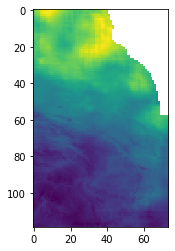

In [121]:
# print(block_averaged_list[0][0])
# averaged_array = rastermath(block_daily_annual_list,0)
# print(averaged_array)
# print(block_averaged_list)
# print(block_averaged_list[0])
plt.imshow(block_averaged_list[0][0])

In [104]:
rastermath(block_daily_annual_list,0)[0]

[array([[1.655     , 1.735     , 1.775     , ...,        nan,        nan,
                nan],
        [1.64      , 1.73      , 1.78      , ...,        nan,        nan,
                nan],
        [1.62      , 1.72      , 1.765     , ...,        nan,        nan,
                nan],
        ...,
        [0.835     , 0.815     , 0.79499996, ..., 0.69      , 0.705     ,
         0.71      ],
        [0.815     , 0.78499997, 0.775     , ..., 0.695     , 0.71500003,
         0.725     ],
        [0.78499997, 0.755     , 0.74      , ..., 0.70500004, 0.725     ,
         0.74      ]], dtype=float32)]

In [48]:
block_daily_annual_list

[<open DatasetReader name='s3://dev-et-data/in/DelawareRiverBasin/ETo/1955/reference_evapotranspiration_1955001.tif' mode='r'>,
 <open DatasetReader name='s3://dev-et-data/in/DelawareRiverBasin/ETo/1955/reference_evapotranspiration_1955002.tif' mode='r'>,
 <open DatasetReader name='s3://dev-et-data/in/DelawareRiverBasin/ETo/1955/reference_evapotranspiration_1955003.tif' mode='r'>,
 <open DatasetReader name='s3://dev-et-data/in/DelawareRiverBasin/ETo/1955/reference_evapotranspiration_1955004.tif' mode='r'>,
 <open DatasetReader name='s3://dev-et-data/in/DelawareRiverBasin/ETo/1955/reference_evapotranspiration_1955005.tif' mode='r'>,
 <open DatasetReader name='s3://dev-et-data/in/DelawareRiverBasin/ETo/1955/reference_evapotranspiration_1955006.tif' mode='r'>,
 <open DatasetReader name='s3://dev-et-data/in/DelawareRiverBasin/ETo/1955/reference_evapotranspiration_1955007.tif' mode='r'>,
 <open DatasetReader name='s3://dev-et-data/in/DelawareRiverBasin/ETo/1955/reference_evapotranspiration_

In [27]:
fs = fsspec.filesystem('s3', anon=False, requester_pays=True)
all_files = fs.find('dev-et-data/in/DelawareRiverBasin/ETo/')
# print(all_files)
# print(grepfxn('1964',all_files))

year_block_annual = np.arange(averaging_years[0], averaging_years[0+1], 1)
print(year_block_annual)
print(str(year_block_annual[5]))

[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959]
1955


In [ ]:
year_block_annual_list = []

year_annual_loop_geotiff = grepfxn(str(year_block_annual[5]),all_files)
print(year_annual_loop_geotiff)


In [ ]:
year_daily_loop_geotiff = year_annual_loop_geotiff[0]
print(year_daily_loop_geotiff)

In [ ]:
daily_constructed_filename = "s3://" + year_daily_loop_geotiff 

print(daily_constructed_filename)

In [ ]:
test=rio.open(daily_constructed_filename)
print(test)

In [ ]:
year_daily_loop_geotiff2 = year_annual_loop_geotiff[1]
daily_constructed_filename2 = "s3://" + year_daily_loop_geotiff2 
test2=rio.open(daily_constructed_filename2)

In [ ]:
rastermath([test,test2],0)

In [ ]:
# print(year_annual_loop_geotiff)
print(year_daily_loop_geotiff)
print(year_block_annual)
print(year_block_annual[5])
year_annual_loop_geotiff = grepfxn(str(year_block_annual[5]),all_files); print(year_annual_loop_geotiff)

In [ ]:
print(year_annual_loop)
print(str(year_annual_loop))
year_annual_loop_geotiff = grepfxn(str(year_annual_loop),all_files)
# print(year_annual_loop_geotiff)

In [ ]:
print(averaging_years)
print(averaging_years2)
year_block_annual

In [ ]:
year_annual_loop_geotiff

In [ ]:
print(averaging_years)
year_block_annual = np.arange(averaging_years[0], averaging_years[0+1], 1)
range(0, len(year_block_annual))